In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Load Data 

In [2]:
BASE_DIR = "/kaggle/input/nfl-player-contact-detection"

labels = pd.read_csv(f"{BASE_DIR}/train_labels.csv", parse_dates=["datetime"])

train_player_tracking = pd.read_csv(
    f"{BASE_DIR}/train_player_tracking.csv", parse_dates=["datetime"]
)
test_player_tracking = pd.read_csv(
    f"{BASE_DIR}/test_player_tracking.csv", parse_dates=["datetime"]
)

# Baseline helmet detection labels
train_helmets = pd.read_csv(f"{BASE_DIR}/train_baseline_helmets.csv")
test_helmets = pd.read_csv(f"{BASE_DIR}/test_baseline_helmets.csv")

# Video metadata with start/stop timestamps
train_video_metadata = pd.read_csv(
    "../input/nfl-player-contact-detection/train_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)


## train_player_tracking

In [3]:
#report = ProfileReport(train_player_tracking)
#report

In [4]:
# show first entries
train_player_tracking.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10 21:08:20.900000+00:00,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10 21:08:20.900000+00:00,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10 21:08:20.900000+00:00,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10 21:08:20.900000+00:00,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10 21:08:20.900000+00:00,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [5]:
#show last entries
train_player_tracking.tail()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
1353048,58575_003081,58575,3081,48476,2021-10-10 19:22:06.800000+00:00,140,away,CB,40,72.28,51.80,1.59,0.17,345.36,342.68,0.49,-0.41
1353049,58575_003081,58575,3081,44887,2021-10-10 19:22:06.800000+00:00,140,away,ILB,45,74.76,54.50,0.98,0.10,342.39,354.46,0.63,-0.24
1353050,58575_003081,58575,3081,44174,2021-10-10 19:22:06.800000+00:00,140,away,ILB,49,74.54,55.75,1.12,0.11,352.79,349.20,0.63,0.46
1353051,58575_003081,58575,3081,45217,2021-10-10 19:22:06.800000+00:00,140,away,TE,82,80.44,48.77,1.93,0.20,340.78,346.51,0.53,-0.51
1353052,58575_003081,58575,3081,43757,2021-10-10 19:22:06.800000+00:00,140,home,SS,26,110.56,24.05,2.64,0.27,231.91,230.50,0.46,-0.41


In [6]:
# data types, NaN count, columns
train_player_tracking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353053 entries, 0 to 1353052
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   game_play      1353053 non-null  object             
 1   game_key       1353053 non-null  int64              
 2   play_id        1353053 non-null  int64              
 3   nfl_player_id  1353053 non-null  int64              
 4   datetime       1353053 non-null  datetime64[ns, UTC]
 5   step           1353053 non-null  int64              
 6   team           1353053 non-null  object             
 7   position       1353053 non-null  object             
 8   jersey_number  1353053 non-null  int64              
 9   x_position     1353053 non-null  float64            
 10  y_position     1353053 non-null  float64            
 11  speed          1353053 non-null  float64            
 12  distance       1353053 non-null  float64            
 13  direction   

In [7]:
# check for duplicate data
train_player_tracking.nunique()

game_play          240
game_key           149
play_id            233
nfl_player_id     1687
datetime         61279
step              1032
team                 2
position            28
jersey_number       99
x_position       12295
y_position        6893
speed             1057
distance           144
direction        36001
orientation      36001
acceleration       840
sa                1504
dtype: int64

In [8]:
# statistics summary
train_player_tracking.describe().T

,count,mean,std,min,25%,50%,75%,max
game_key,1353053.0,58365.798892,137.696060,58168.00,58225.00,58330.00,58516.00,58582.00
play_id,1353053.0,2156.408095,1211.457383,40.00,1016.00,2369.00,3139.00,4644.00
nfl_player_id,1353053.0,44747.017081,4831.883106,25511.00,42352.00,44893.00,47814.00,53985.00
step,1353053.0,-11.900465,112.549475,-339.00,-86.00,-15.00,49.00,692.00
jersey_number,1353053.0,51.282450,28.636098,1.00,25.00,52.00,76.00,99.00
x_position,1353053.0,60.308048,26.815381,-7.47,38.48,59.69,81.71,125.65
y_position,1353053.0,26.758909,8.507395,-12.87,22.49,26.74,31.04,63.72
speed,1353053.0,1.259892,1.658213,0.00,0.12,0.65,1.62,14.89
distance,1353053.0,0.128708,0.166647,0.00,0.02,0.07,0.16,2.22
direction,1353053.0,179.698862,104.000522,0.00,90.03,179.24,269.33,360.00


In [9]:
# seperate the categorical and numerical columns
categorical_cols = train_player_tracking.select_dtypes(include=['object']).columns
numerical_cols = train_player_tracking.select_dtypes(include=np.number).columns.tolist()
print("Categorical Features:")
print(categorical_cols)
print("Numerical Features:")
print(numerical_cols)

Categorical Features:
Index(['game_play', 'team', 'position'], dtype='object')
Numerical Features:
['game_key', 'play_id', 'nfl_player_id', 'step', 'jersey_number', 'x_position', 'y_position', 'speed', 'distance', 'direction', 'orientation', 'acceleration', 'sa']


#### Univariate EDA

game_key
Skew : 0.18


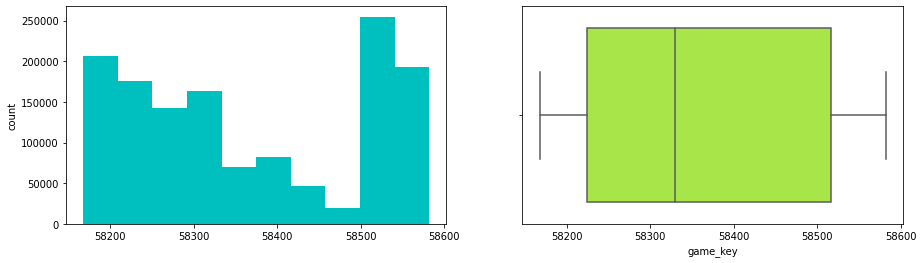

play_id
Skew : -0.12


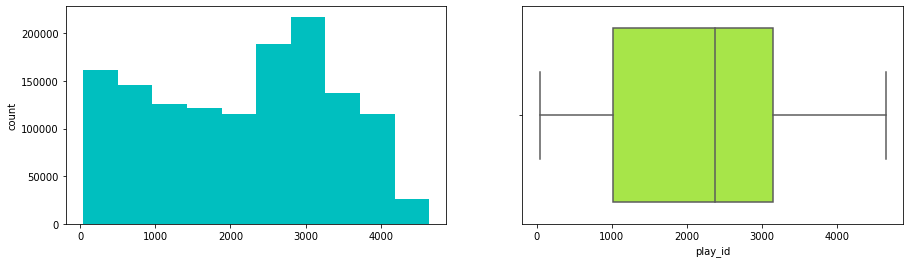

nfl_player_id
Skew : -0.34


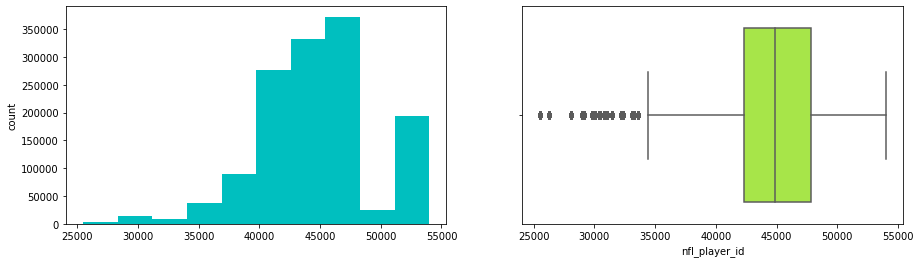

step
Skew : 1.19


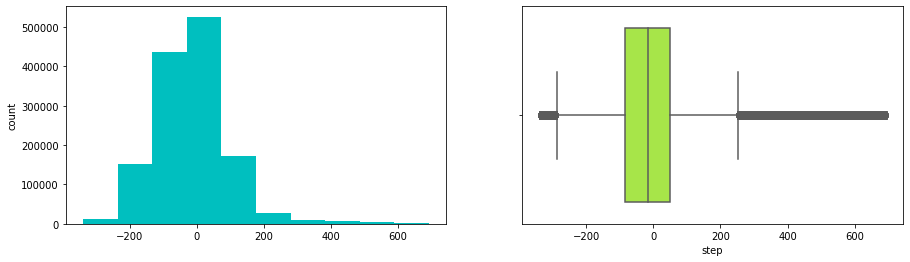

jersey_number
Skew : 0.04


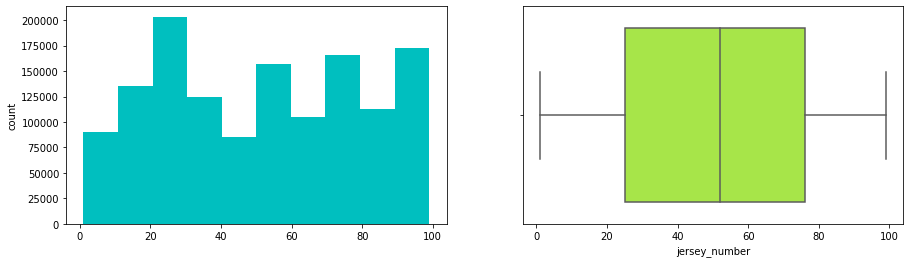

x_position
Skew : 0.04


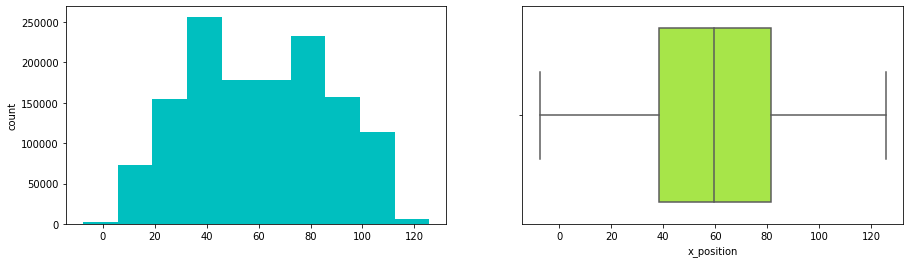

y_position
Skew : 0.01


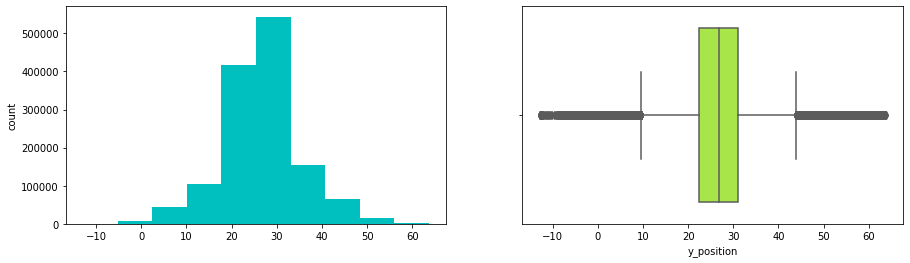

speed
Skew : 2.13


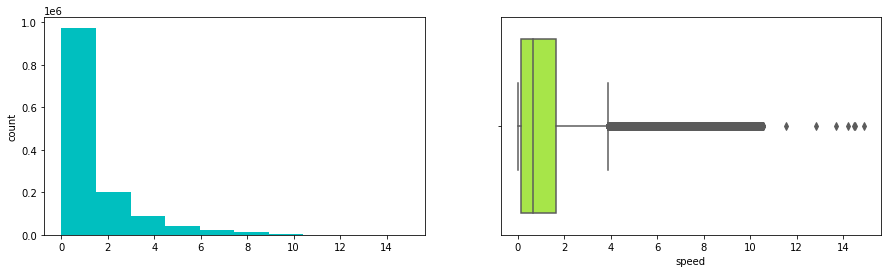

distance
Skew : 2.15


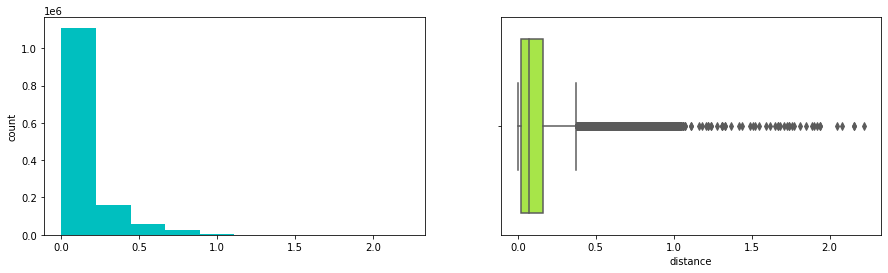

direction
Skew : 0.01


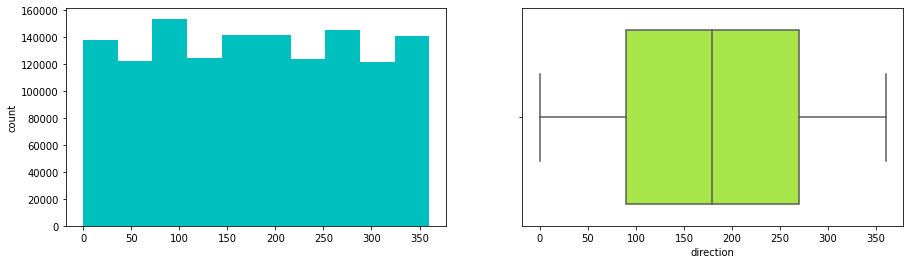

orientation
Skew : 0.01


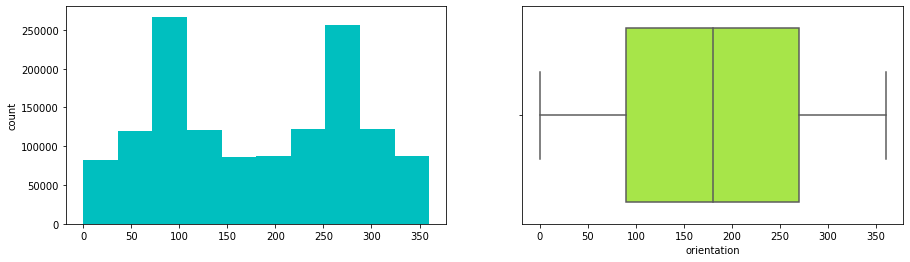

acceleration
Skew : 2.2


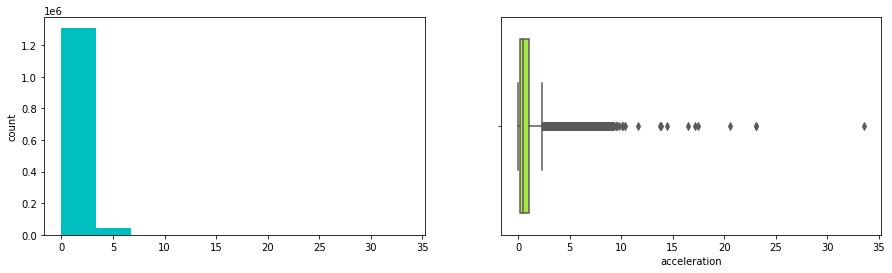

sa
Skew : 0.58


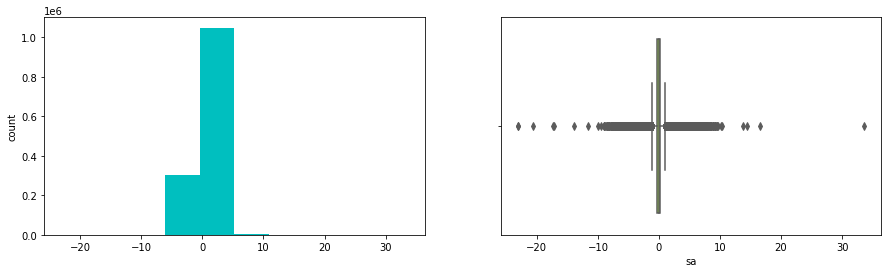

In [10]:
for f in numerical_cols:
    print(f)
    print('Skew :', round(train_player_tracking[f].skew(), 2))
    print("============================")
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    train_player_tracking[f].hist(grid=False, color='c')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_player_tracking[f], color='greenyellow')
    plt.show()

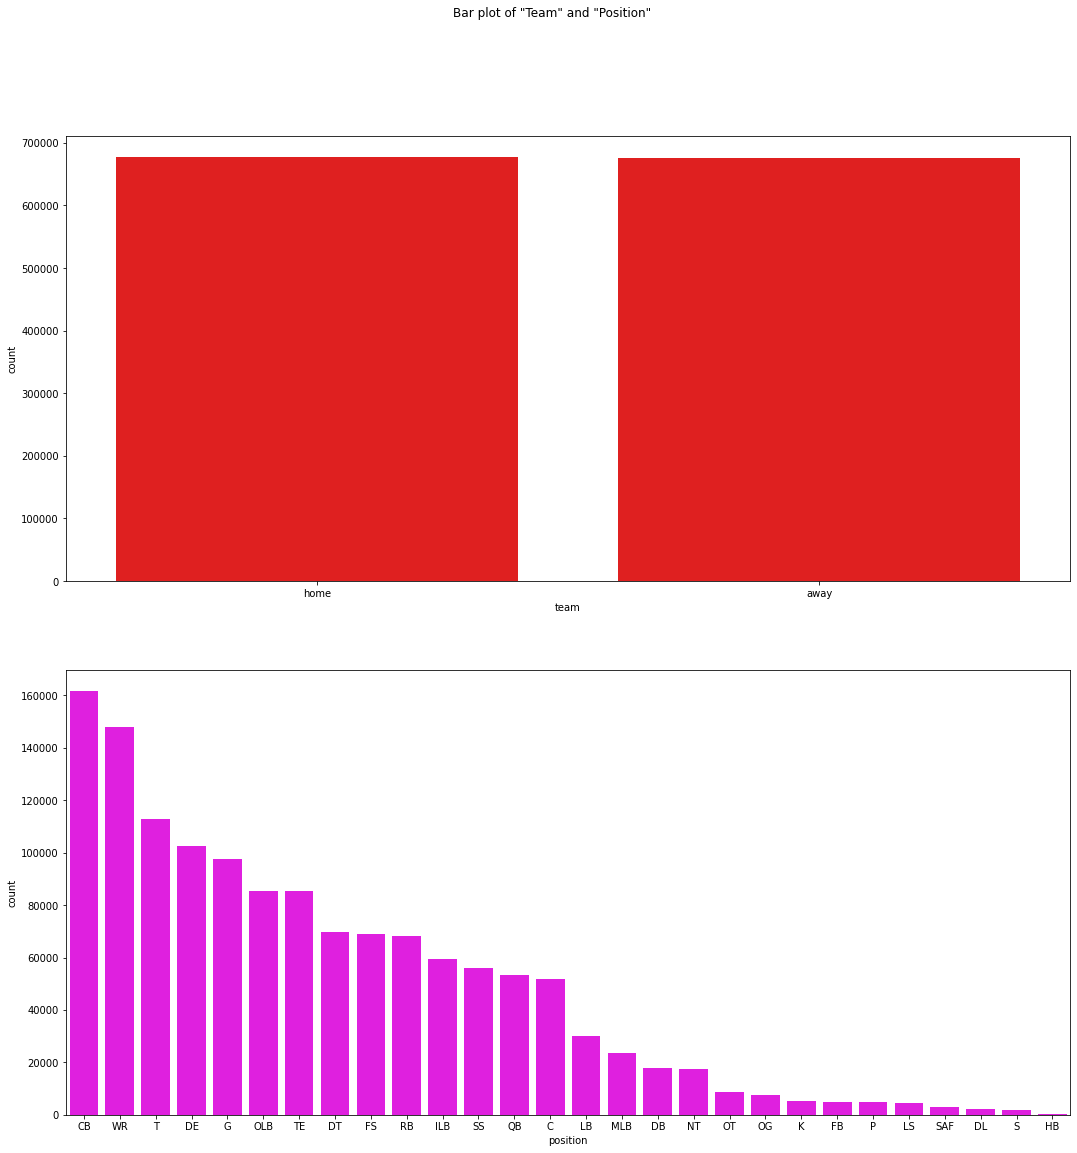

In [11]:
fig, axes = plt.subplots(2, figsize = (18, 18))
fig.suptitle('Bar plot of "Team" and "Position"')
sns.countplot(ax = axes[0], x = 'team', data = train_player_tracking, color = 'red', 
              order = train_player_tracking['team'].value_counts().index);
sns.countplot(ax = axes[1], x = 'position', data = train_player_tracking, color = 'magenta', 
              order = train_player_tracking['position'].value_counts().index);